In [ ]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 256, 256, 3)
[1 0 0 1 1 0 0 1]


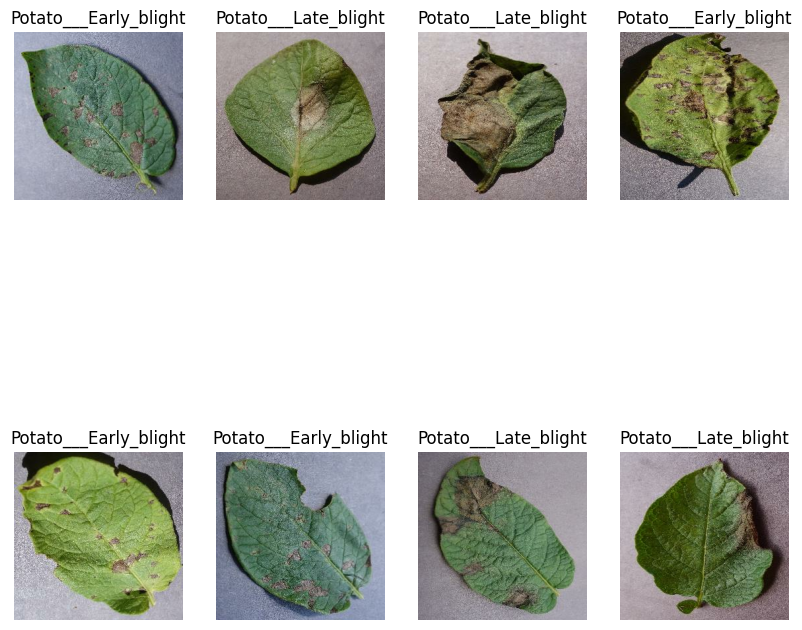

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

375

In [ ]:
train_size = 0.8
len(dataset)*train_size

300.0

In [ ]:
train_ds = dataset.take(300)
len(train_ds)

300

In [ ]:
test_ds = dataset.skip(300)
len(test_ds)

75

In [ ]:
val_size=0.1
len(dataset)*val_size

37.5

In [ ]:
val_ds = test_ds.take(37)
len(val_ds)

37

In [ ]:
test_ds = test_ds.skip(37)
len(test_ds)

38

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  300
Validation Dataset Size:  37
Test Dataset Size:  38


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [ ]:
from tensorflow.keras.applications import ResNet50V2

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = ResNet50V2(include_top = False, weights = 'imagenet', input_shape = input_shape)

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                      

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
300/300 [==============================] - 70s 182ms/step - loss: 0.3949 - accuracy: 0.8517 - val_loss: 0.2413 - val_accuracy: 0.9088
Epoch 2/50
300/300 [==============================] - 51s 170ms/step - loss: 0.2563 - accuracy: 0.9071 - val_loss: 0.1827 - val_accuracy: 0.9291
Epoch 3/50
300/300 [==============================] - 51s 170ms/step - loss: 0.2200 - accuracy: 0.9267 - val_loss: 0.2057 - val_accuracy: 0.9189
Epoch 4/50
300/300 [==============================] - 51s 170ms/step - loss: 0.1652 - accuracy: 0.9438 - val_loss: 0.1850 - val_accuracy: 0.9426
Epoch 5/50
300/300 [==============================] - 51s 170ms/step - loss: 0.1731 - accuracy: 0.9450 - val_loss: 0.1035 - val_accuracy: 0.9730
Epoch 6/50
300/300 [==============================] - 52s 174ms/step - loss: 0.1572 - accuracy: 0.9488 - val_loss: 0.1151 - val_accuracy: 0.9628
Epoch 7/50
300/300 [==============================] - 51s 171ms/step - loss: 0.1557 - accuracy: 0.9513 - val_loss: 0.1024 - val_ac

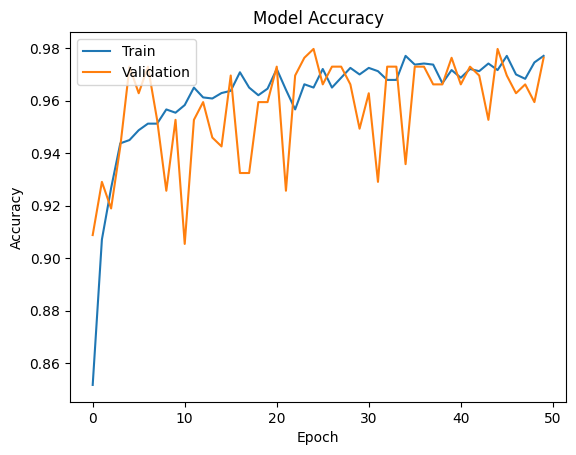

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

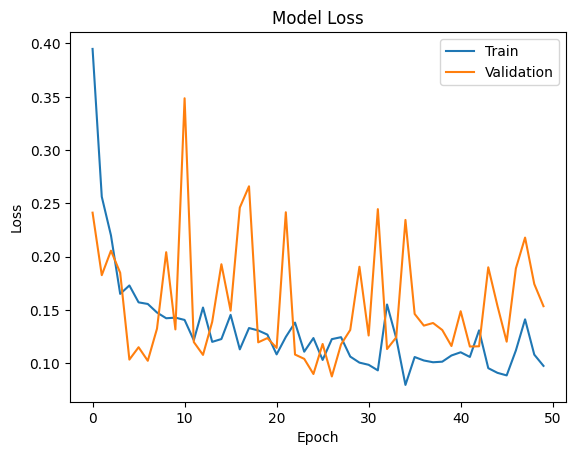

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

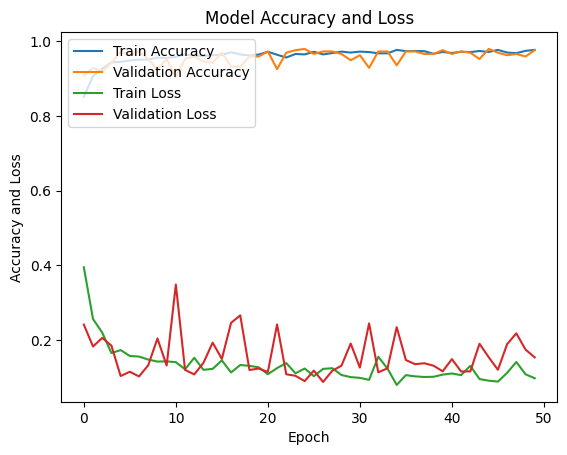

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

38/38 [==============================] - 6s 96ms/step - loss: 0.1495 - accuracy: 0.9737


[0.8516666889190674,
 0.9070833325386047,
 0.9266666769981384,
 0.9437500238418579,
 0.9449999928474426,
 0.9487500190734863,
 0.9512500166893005,
 0.9512500166893005,
 0.9566666483879089,
 0.9554166793823242,
 0.9583333134651184,
 0.9649999737739563,
 0.9612500071525574,
 0.9608333110809326,
 0.9629166722297668,
 0.9637500047683716,
 0.9708333611488342,
 0.9649999737739563,
 0.9620833396911621,
 0.9645833373069763,
 0.972083330154419,
 0.9641666412353516,
 0.9566666483879089,
 0.9662500023841858,
 0.9649999737739563,
 0.972083330154419,
 0.9649999737739563,
 0.96875,
 0.9725000262260437,
 0.9700000286102295,
 0.9725000262260437,
 0.9712499976158142,
 0.9679166674613953,
 0.9679166674613953,
 0.9770833253860474,
 0.9737499952316284,
 0.9741666913032532,
 0.9737499952316284,
 0.9666666388511658,
 0.971666693687439,
 0.96875,
 0.972083330154419,
 0.9712499976158142,
 0.9741666913032532,
 0.971666693687439,
 0.9770833253860474,
 0.9700000286102295,
 0.9683333039283752,
 0.9745833277702332

In [ ]:
history.history['val_accuracy']

[0.9087837934494019,
 0.9290540814399719,
 0.9189189076423645,
 0.9425675868988037,
 0.9729729890823364,
 0.962837815284729,
 0.9729729890823364,
 0.9527027010917664,
 0.9256756901741028,
 0.9527027010917664,
 0.9054054021835327,
 0.9527027010917664,
 0.9594594836235046,
 0.9459459185600281,
 0.9425675868988037,
 0.9695945978164673,
 0.9324324131011963,
 0.9324324131011963,
 0.9594594836235046,
 0.9594594836235046,
 0.9729729890823364,
 0.9256756901741028,
 0.9695945978164673,
 0.9763513803482056,
 0.9797297120094299,
 0.9662162065505981,
 0.9729729890823364,
 0.9729729890823364,
 0.9662162065505981,
 0.9493243098258972,
 0.962837815284729,
 0.9290540814399719,
 0.9729729890823364,
 0.9729729890823364,
 0.9358108043670654,
 0.9729729890823364,
 0.9729729890823364,
 0.9662162065505981,
 0.9662162065505981,
 0.9763513803482056,
 0.9662162065505981,
 0.9729729890823364,
 0.9695945978164673,
 0.9527027010917664,
 0.9797297120094299,
 0.9695945978164673,
 0.962837815284729,
 0.9662162065505

In [ ]:
history.history['loss']

[0.3948962390422821,
 0.25628405809402466,
 0.2199840098619461,
 0.1651652753353119,
 0.17307144403457642,
 0.15721265971660614,
 0.15571098029613495,
 0.1476808488368988,
 0.14230689406394958,
 0.1428874135017395,
 0.1407262086868286,
 0.12169494479894638,
 0.15236112475395203,
 0.12016476690769196,
 0.12280929833650589,
 0.14548739790916443,
 0.11313427239656448,
 0.13312463462352753,
 0.13086190819740295,
 0.12695258855819702,
 0.10842974483966827,
 0.12479035556316376,
 0.13823722302913666,
 0.11094360053539276,
 0.12374772131443024,
 0.1032092496752739,
 0.12271670252084732,
 0.12455018609762192,
 0.10636080056428909,
 0.1006990298628807,
 0.09865528345108032,
 0.09343870729207993,
 0.15521450340747833,
 0.12361560761928558,
 0.07978550344705582,
 0.10594356060028076,
 0.10270145535469055,
 0.10103873908519745,
 0.10158371925354004,
 0.10740098357200623,
 0.11040317267179489,
 0.10601678490638733,
 0.13095217943191528,
 0.09550788998603821,
 0.09111151099205017,
 0.088712543249130

In [ ]:
history.history['val_loss']

[0.24133671820163727,
 0.18271219730377197,
 0.2056935727596283,
 0.1849718540906906,
 0.10353472083806992,
 0.11512134969234467,
 0.10243026167154312,
 0.13251671195030212,
 0.20425665378570557,
 0.13184091448783875,
 0.3486248850822449,
 0.12002971768379211,
 0.10794160515069962,
 0.13897719979286194,
 0.19298361241817474,
 0.14941754937171936,
 0.24608127772808075,
 0.26607054471969604,
 0.11972355097532272,
 0.12371720373630524,
 0.1145225241780281,
 0.2417254000902176,
 0.10828563570976257,
 0.10423137992620468,
 0.09001760184764862,
 0.1182047501206398,
 0.08772920072078705,
 0.11777641624212265,
 0.13133959472179413,
 0.19061589241027832,
 0.12613876163959503,
 0.24465125799179077,
 0.1134449690580368,
 0.1243838220834732,
 0.23451805114746094,
 0.14635604619979858,
 0.13540828227996826,
 0.13785672187805176,
 0.13129840791225433,
 0.11626078933477402,
 0.1488998830318451,
 0.11578653007745743,
 0.11600635945796967,
 0.19011275470256805,
 0.15384913980960846,
 0.1203285455703735

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.9736841917037964
Loss:  0.14948587119579315


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

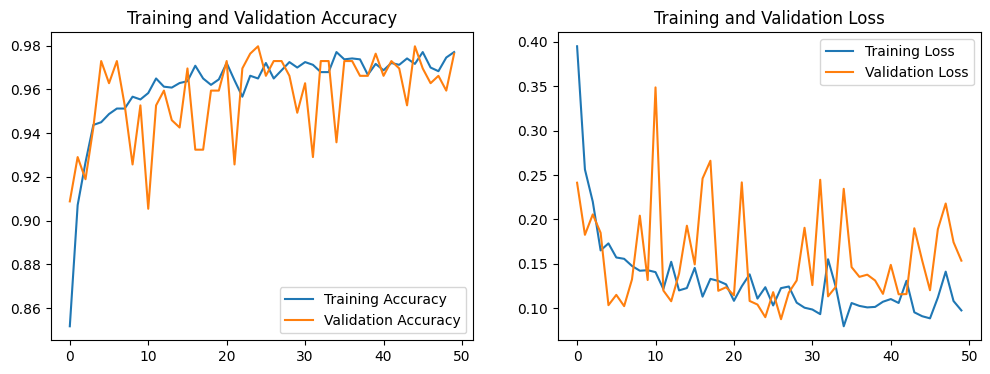

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Late_blight
1/1 [==============================] - 1s 953ms/step
[1.3670134e-10 1.0000000e+00 3.9993255e-11]
Max Value: 1
Predicted Label: Potato___Late_blight


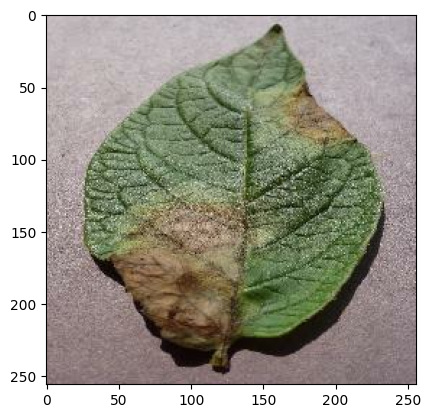

In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


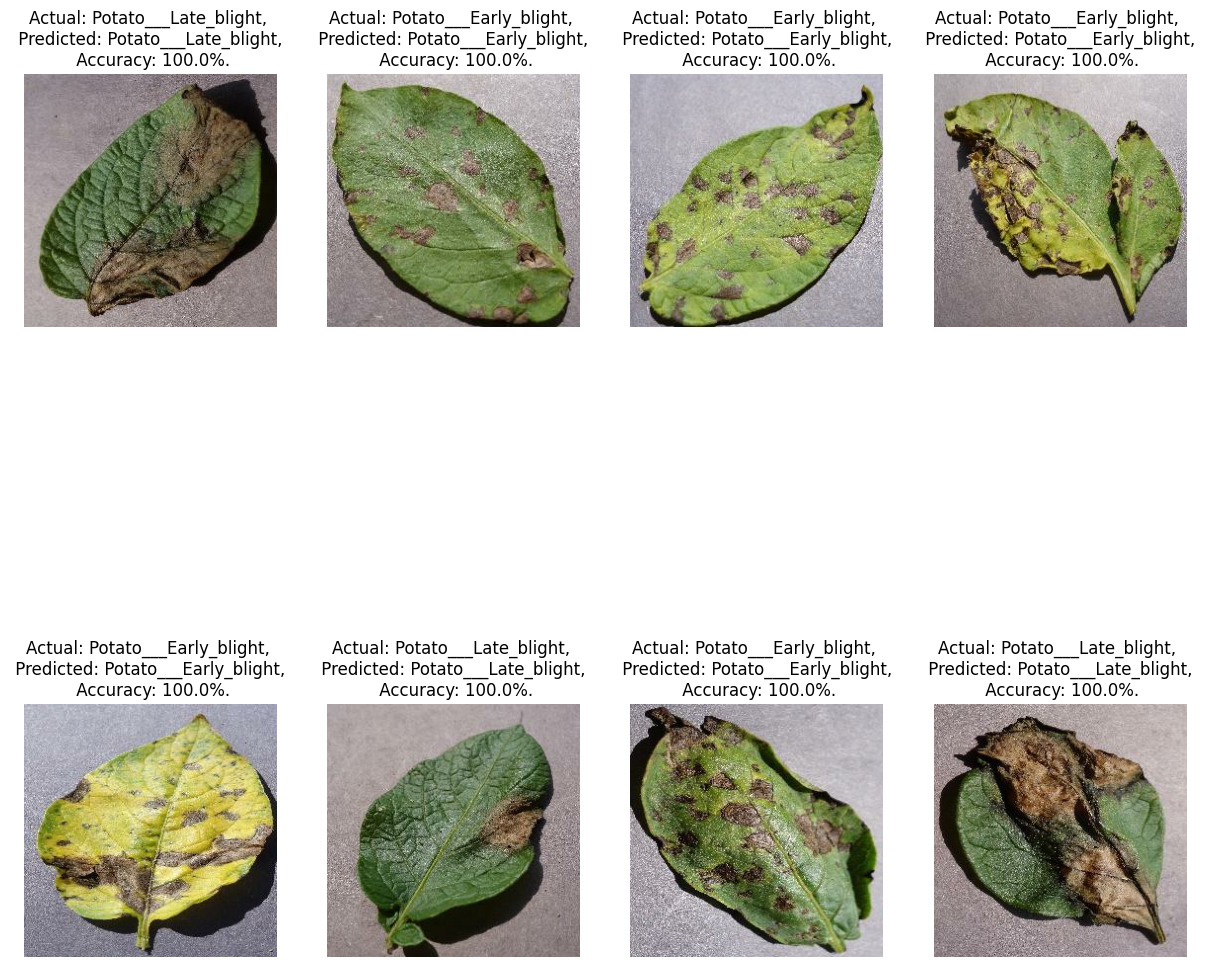

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [ ]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  97.36841917037964


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

38/38 [==============================] - 4s 91ms/step
F1 Score:  34.83813891899487
Precision Score:  34.81563804618085
Recall Score:  34.868421052631575


38/38 [==============================] - 3s 91ms/step


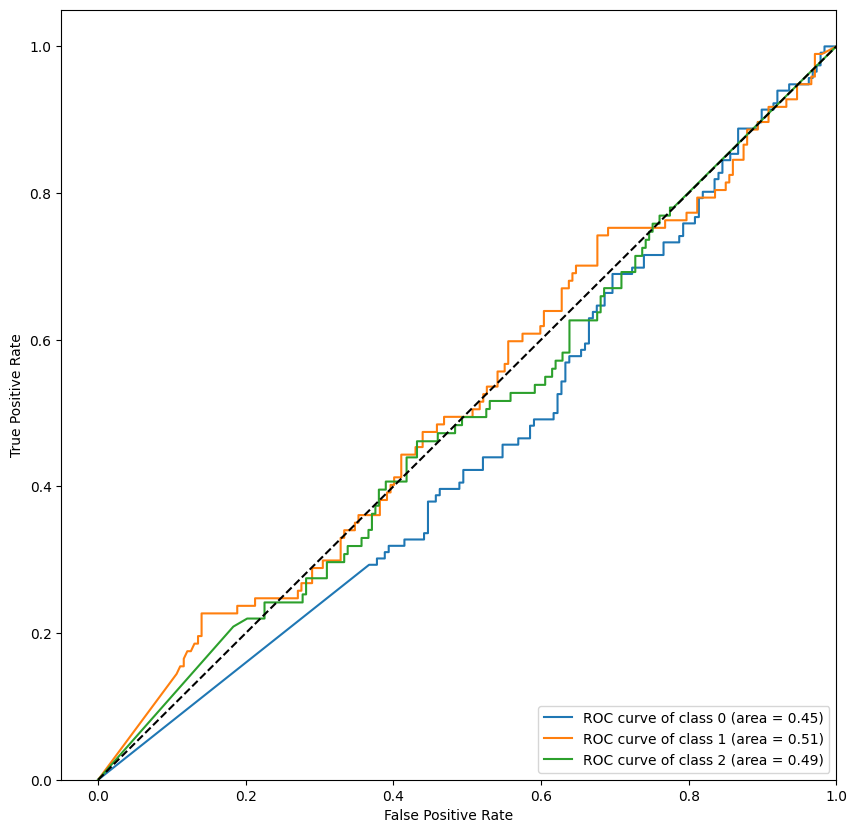

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

38/38 [==============================] - 3s 91ms/step


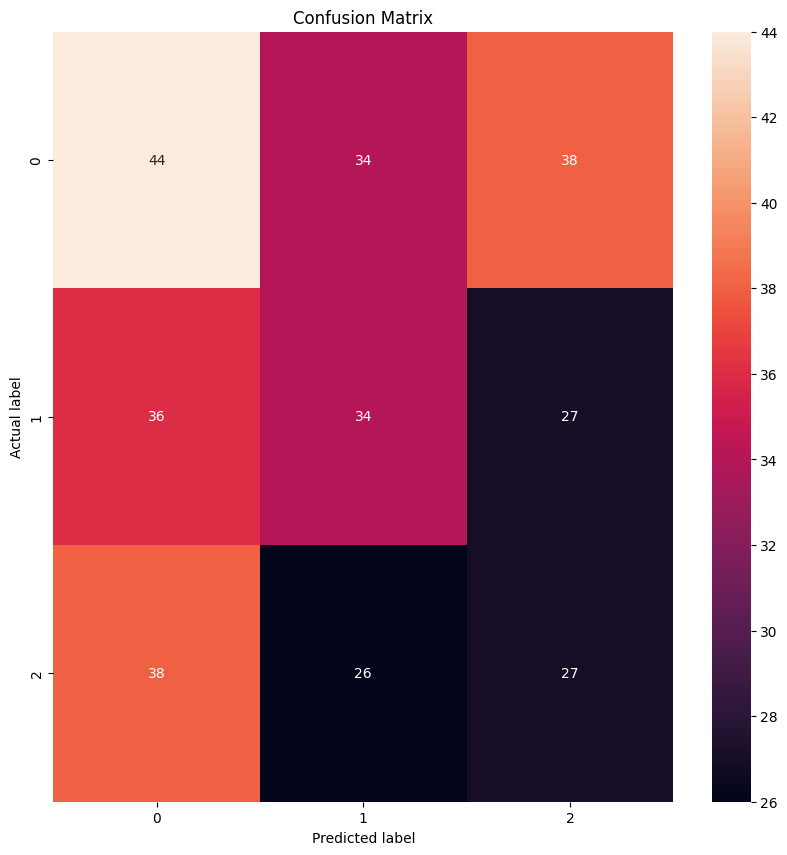

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()